In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import random
from os import environ 
import matplotlib.pyplot as plt
import seaborn as sns
from components import *

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything()
    
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

OUTPUT_PATH = './Model'

cuda:0


In [3]:
df = pd.read_csv("./Data/complete_dataset.csv")

In [4]:
df.head()

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday
0,2015-01-01,199270.06,25.633696,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9,N,Y
1,2015-01-02,259212.02,33.138988,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8,N,N
2,2015-01-03,284601.08,34.564855,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2,N,N
3,2015-01-04,208661.43,25.005560,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4,N,N
4,2015-01-05,236264.40,26.724176,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0,N,N


In [5]:
df['SchoolDay'] = df['SchoolDay'].map({'N' : 0, 'Y' : 1})
df['Holiday'] = df['Holiday'].map({'N' : 0, 'Y' : 1})
df.head()

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday
0,2015-01-01,199270.06,25.633696,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9,0,1
1,2015-01-02,259212.02,33.138988,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8,0,0
2,2015-01-03,284601.08,34.564855,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2,0,0
3,2015-01-04,208661.43,25.005560,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4,0,0
4,2015-01-05,236264.40,26.724176,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0,0,0


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['DoW_cos'] = df['Date'].apply(lambda x: np.cos(2*np.pi*x.dayofweek/7))
df['DoW_sin'] = df['Date'].apply(lambda x: np.sin(2*np.pi*x.dayofweek/7))
df['WoY_cos'] = df['Date'].apply(lambda x: np.cos(2*np.pi*x.weekofyear/52))
df['WoY_sin'] = df['Date'].apply(lambda x: np.sin(2*np.pi*x.weekofyear/52))
df['Year'] = df['Date'].dt.year
df['Year'] = (df['Year'] - df['Year'].min())/(df['Year'].max() - df['Year'].min())
df

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday,DoW_cos,DoW_sin,WoY_cos,WoY_sin,Year
0,2015-01-01,199270.06,25.633696,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9,0,1,-0.900969,0.433884,0.992709,0.120537,0.0
1,2015-01-02,259212.02,33.138988,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8,0,0,-0.900969,-0.433884,0.992709,0.120537,0.0
2,2015-01-03,284601.08,34.564855,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2,0,0,-0.222521,-0.974928,0.992709,0.120537,0.0
3,2015-01-04,208661.43,25.005560,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4,0,0,0.623490,-0.781831,0.992709,0.120537,0.0
4,2015-01-05,236264.40,26.724176,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0,0,0,1.000000,0.000000,0.970942,0.239316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,199171.67,-6.076028,83976.48,11.375646,115195.19,-17.451675,0.625000,12.8,26.0,0,0,-0.900969,-0.433884,0.120537,-0.992709,1.0
2102,2020-10-03,184554.05,-1.983471,88267.02,15.514259,96287.03,-17.497730,0.583333,17.4,29.4,0,0,-0.222521,-0.974928,0.120537,-0.992709,1.0
2103,2020-10-04,188163.13,25.008614,177161.99,25.018147,11001.14,-0.009534,0.062500,13.5,29.5,0,0,0.623490,-0.781831,0.120537,-0.992709,1.0
2104,2020-10-05,227220.06,36.764701,213174.75,37.167203,14045.31,-0.402503,0.083333,9.1,12.7,0,0,1.000000,0.000000,0.239316,-0.970942,1.0


Validation set will start from this point.

In [7]:
val_start_id = df[df['Date'] == pd.to_datetime('01-01-2019')].index[0]

Test set will start from this point. If the model works well on valid set, any discrepancies between the data and the model may serve as a leading indicator of changing a economic outlook.

In [8]:
test_start_id = df[df['Date'] == pd.to_datetime('01-01-2020')].index[0]

In [9]:
"""
Train scaler on Train set only.
Scale train, val and test sets after.
"""

from sklearn.preprocessing import StandardScaler

def shift_log(df, col_name):
    """
    Transform by shift so that min element = 1 and taking log
    """
    vals = df[col_name].values
    shift = np.min(vals)
    vals = np.log(vals - shift + 1)
    df[col_name + " (mod)"] = (vals - vals.mean())/vals.std()


raw_cols = ['Minimum Temperature', 'Maximum Temperature', 
              'FracNegative', 'nRRP', 'pRRP', 
              'nDemand', 'pDemand']

scaled_cols = [col + " (sc)" for col in raw_cols]

# Scaling function for demand (avoids conversion from torch.Tensor)
train_demand = df[:val_start_id][['Demand']].values
mean = train_demand.mean()
std = train_demand.std()
def demand_scaler(x):
    return (x - mean)/std

scaler = StandardScaler()

scaler.fit(df[:val_start_id][raw_cols])

df[scaled_cols] = scaler.transform(df[raw_cols])
df['Demand (sc)'] = demand_scaler(df[['Demand']].values)

In [10]:
train_df = df[:val_start_id]
val_df = df[val_start_id-14:test_start_id]
test_df = df[test_start_id-14:]

In [11]:
ignore_columns = ['Date', 'RRP', 'pDemand', 'pRRP', 'nDemand', 'nRRP', 'FracNegative']
decoder_columns = ['Minimum Temperature (sc)', 'Maximum Temperature (sc)', 'SchoolDay', 
                   'Holiday', 'DoW_cos', 'DoW_sin', 'WoY_cos', 'WoY_sin', 'Year']
encoder_columns = decoder_columns + ['Demand (sc)', 'RRP (sc)', 'pDemand (sc)', 
                                     'pRRP (sc)', 'nDemand (sc)', 'nRRP (sc)', 'FracNegative (sc)']

w = WindowGenerator(input_width=14, target_width=7,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    ignore_columns = ignore_columns,
                    target_columns=['Demand'], 
                    encoder_columns=encoder_columns, 
                    decoder_columns=decoder_columns)
w

Encoder columns : ['Demand (sc)', 'DoW_cos', 'DoW_sin', 'FracNegative (sc)', 'Holiday', 'Maximum Temperature (sc)', 'Minimum Temperature (sc)', 'SchoolDay', 'WoY_cos', 'WoY_sin', 'Year', 'nDemand (sc)', 'nRRP (sc)', 'pDemand (sc)', 'pRRP (sc)']
Decoder columns : ['DoW_cos', 'DoW_sin', 'Holiday', 'Maximum Temperature (sc)', 'Minimum Temperature (sc)', 'SchoolDay', 'WoY_cos', 'WoY_sin', 'Year']
Target columns : ['Demand']
Input size: 14
Target size: 7

Test windows generator

In [12]:
w.gen_batches(3)
sample_enc_batch, sample_dec_batch, sample_tgt_batch = w.batch(idx = 1)
print(f"Encoder training batch shape {sample_enc_batch.shape}")
print(f"Decoder training batch shape {sample_dec_batch.shape}")
print(f"Target batch shape {sample_tgt_batch.shape}")

Encoder training batch shape (3, 14, 15)
Decoder training batch shape (3, 7, 9)
Target batch shape (3, 7, 1)


Test Encoder

In [13]:
smpl_encoder = Encoder(num_features=sample_enc_batch.shape[-1], hidden_size=100)
smpl_hidden = smpl_encoder.init_hidden(sample_enc_batch.shape[0])
x = torch.from_numpy(sample_enc_batch).type(torch.FloatTensor)
smpl_output, smpl_hidden = smpl_encoder(x, smpl_hidden)
print("sample output shape: ", smpl_output.shape)
print("sample hidden shape: ", smpl_hidden.shape)

sample output shape:  torch.Size([3, 14, 100])
sample hidden shape:  torch.Size([3, 100])


/home/alex/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:57: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
smpl_decoder = Decoder(num_features=sample_dec_batch.shape[-1], hidden_size=100)
x = torch.from_numpy(sample_dec_batch[:, 0, :]).type(torch.FloatTensor)
smpl_output, smpl_hidden = smpl_decoder(x, smpl_hidden)
print("sample output shape: ", smpl_output.shape)
print("sample hidden shape: ", smpl_hidden.shape)

sample output shape:  torch.Size([3, 1])
sample hidden shape:  torch.Size([3, 100])


In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, num_enc_features, num_dec_features, hidden_size, tgt_scaler=None,
                 num_enc_layers = 1, enc_droupout=0.1, dec_droupout=0.1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(num_enc_features, hidden_size, 
                               num_enc_layers, enc_droupout)
        self.decoder = Decoder(num_dec_features, hidden_size, dec_droupout)
        # Target scaler is applied to last prediction when feeding forward
        self.tgt_scaler = tgt_scaler
        self.hidden = None
        
    def forward(self, enc_batch, dec_batch, forcing = 0):
        """
        teacher forcing = 0 amounts can be used for inference.
        teacher forcing > 0 is a training mode.
        """
        output_enc, hidden_enc = self.encoder(enc_batch, self.hidden)
        
        hidden_dec = hidden_enc
        
        pred = torch.zeros((dec_batch.shape[0], dec_batch.shape[1], 1), device=dec_batch.device)
        
        for t, dec_inp, in enumerate(dec_batch.transpose(0, 1)):               
            output, hidden_dec = self.decoder(dec_inp, hidden_dec)            
            pred[:, t, :] = output
            
        return pred
    
    
    def init_hidden(self, batch_size, device):
        # Important!! Run before forward()
        self.hidden = self.encoder.init_hidden(batch_size).to(device)

In [16]:
def train(model, optimizer, window_generator, batch_size, output_path, scheduler = None,
          num_epochs = 20, random = False, valid_period = 1, save_after = None):
    """
    training routine.
    "valid_period" is a float between 0 and 1.
    For 1 validation is done at the end of training.
    If it is less than 1, validation is done in the middle of the training.
    Setting "valid_period" to 0 results in no validation.
    """
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    valid_period = np.clip(valid_period, 0, 1)
    
    model.train()
    
    DType = torch.FloatTensor
    
    # Train loop
    for epoch in range(num_epochs):
        
        train_start_idxs = window_generator.gen_batches(batch_size, random=True, source='train')
        valid_every = window_generator.number_of_batches(batch_size, "train")

        for idx in train_start_idxs:
            enc_batch, dec_batch, tgt_batch = w.batch(idx, source='train')
            enc_batch = torch.from_numpy(enc_batch).type(DType).to(device)
            dec_batch = torch.from_numpy(dec_batch).type(DType).to(device)
            tgt_batch = torch.from_numpy(tgt_batch).type(DType).to(device)
            
            model.init_hidden(enc_batch.shape[0], device)
            
            y_pred = model(enc_batch, dec_batch)
            
            loss = torch.nn.L1Loss()(y_pred, tgt_batch)
            
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()
            if scheduler: 
                scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_every == 0 and valid_every != 0:
                model.eval()
                val_start_idxs = w.gen_batches(batch_size, source='val')
                with torch.no_grad():  
                    for val_idx in val_start_idxs:
                        val_enc, val_dec, val_tgt = w.batch(val_idx, source='val')
                        val_enc = torch.from_numpy(val_enc).type(DType).to(device)
                        val_dec = torch.from_numpy(val_dec).type(DType).to(device)
                        val_tgt = torch.from_numpy(val_tgt).type(DType).to(device)
                        model.init_hidden(val_enc.shape[0], device)
                        
                        y_pred = model(val_enc, val_dec, forcing = 0)
                        
                        loss = torch.nn.L1Loss()(y_pred, val_tgt)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_every
                valid_loss = valid_loss / len(val_start_idxs)
        
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_start_idxs),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss and global_step > save_after:
                    best_valid_loss = valid_loss
        
                    print("saving model...")
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', 
                                 train_loss_list, 
                                 valid_loss_list, 
                                 global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')
    
    return train_loss_list, valid_loss_list, global_steps_list

In [17]:
EPOCHS = 50
RNN_UNITS = 100
BATCH_SIZE = 20
TARGET_WIDTH = 7

num_enc_features = sample_enc_batch.shape[-1]
num_dec_features = sample_dec_batch.shape[-1]
tgt_scaler = demand_scaler

w = WindowGenerator(input_width=14, target_width=TARGET_WIDTH, 
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    ignore_columns = ignore_columns,
                    target_columns=['Demand'], 
                    encoder_columns=encoder_columns, 
                    decoder_columns=decoder_columns)

model = Seq2Seq(num_enc_features, num_dec_features, hidden_size = RNN_UNITS, 
                enc_droupout=0, dec_droupout=0.1, tgt_scaler = tgt_scaler)

model = model.to(device)


# Set up linear scheduler
steps_per_epochs = w.number_of_batches(batch_size = BATCH_SIZE, source = "train")
num_warmup_steps = 2 * steps_per_epochs
num_training_steps = EPOCHS * steps_per_epochs

SAVE_AFTER_STEP = 30 * steps_per_epochs

def lr(current_step):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(
        0.0, (float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))**2
    )


optimizer = torch.optim.Adam(model.parameters(), lr=10, weight_decay=0)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: lr(step))

In [18]:
train_losses, val_losses, step_list = train(model, optimizer, w, batch_size = BATCH_SIZE, 
                                            num_epochs = EPOCHS, random = True, valid_period = 0.5, 
                                            scheduler = scheduler, output_path = OUTPUT_PATH, 
                                            save_after = SAVE_AFTER_STEP)

Epoch [2/50], global step [74/3600], Train Loss: 236976.0526, Valid Loss: 218983.1467
Epoch [3/50], global step [148/3600], Train Loss: 202246.9740, Valid Loss: 165615.3299
Epoch [4/50], global step [222/3600], Train Loss: 135583.2998, Valid Loss: 90706.3785
Epoch [5/50], global step [296/3600], Train Loss: 63756.4529, Valid Loss: 30554.6641
Epoch [6/50], global step [370/3600], Train Loss: 27614.1169, Valid Loss: 22626.5932
Epoch [7/50], global step [444/3600], Train Loss: 24361.4517, Valid Loss: 23056.3583
Epoch [8/50], global step [518/3600], Train Loss: 23520.0039, Valid Loss: 22484.0648
Epoch [9/50], global step [592/3600], Train Loss: 24693.8789, Valid Loss: 23407.8119
Epoch [10/50], global step [666/3600], Train Loss: 23293.0591, Valid Loss: 21928.4113
Epoch [11/50], global step [740/3600], Train Loss: 23860.2403, Valid Loss: 22282.1997
Epoch [12/50], global step [814/3600], Train Loss: 23901.8966, Valid Loss: 21746.6326
Epoch [13/50], global step [888/3600], Train Loss: 23179.6

Train loss is greater than validation... Nothing surprising, as dropout is on for train loss computation. When it is off (an extra calculation during training), relation between the losses is reverted.

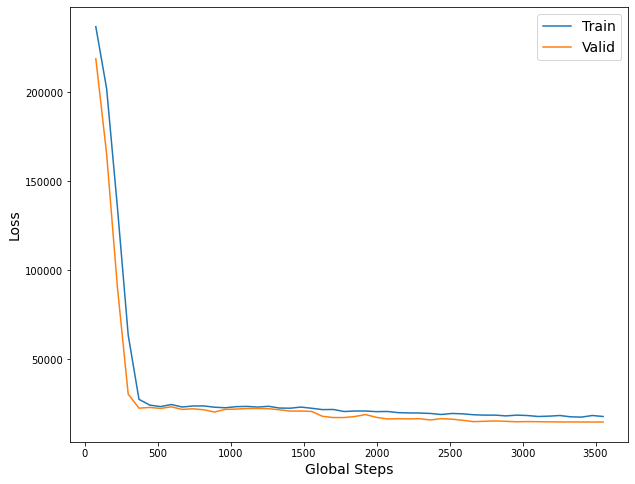

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(step_list, train_losses, label='Train')
plt.plot(step_list, val_losses, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

## Start from this cell to load pre-trained model

In [20]:
model.eval()
load_checkpoint(OUTPUT_PATH + '/model.pkl', model, device)

14850.077799479166

In [21]:
def evaluate(model, df, win_gen):
    """
    Evaluate on a whole dataframe. 
    For every time point save forecast for the following "target_width" points
    """
    model.eval()
    model.init_hidden(1, device)
    
    win_gen.prep_extern_data(df, set_source = 'all_data')
    
    ids = win_gen.gen_batches(batch_size = 1, source = 'all_data')
    print(len(df))
    
    DType = torch.FloatTensor
    
    all_losses = []
    all_pred = []
    
    with torch.no_grad():  
        for i, idx in enumerate(ids):
            all_enc, all_dec, all_tgt = win_gen.batch(idx, source='all_data')
            all_enc = torch.from_numpy(all_enc).type(DType).to(device)
            all_dec = torch.from_numpy(all_dec).type(DType).to(device)
            all_tgt = torch.from_numpy(all_tgt).type(DType).to(device)
                                    
            y_pred = model(all_enc, all_dec)
            all_pred.append(y_pred.squeeze().cpu().numpy())
            
    return np.array(all_pred)

In [22]:
pred = evaluate(model, df, w)

2106


In [23]:
demo_df = df.copy()
demo_df['Demand'] = demo_df['Demand']/1000
demo_df = demo_df.drop([col for col in demo_df.columns if col[-4:] == "(sc)"], axis=1)
for i in range(pred.shape[-1]):
    demo_df[f'Day_{i+1}'] = np.zeros(len(demo_df))
    demo_df.iloc[14 + i:-7 + i, len(demo_df.columns) - 1] = pred[:, i]/1000

In [24]:
sns.set_style("whitegrid")

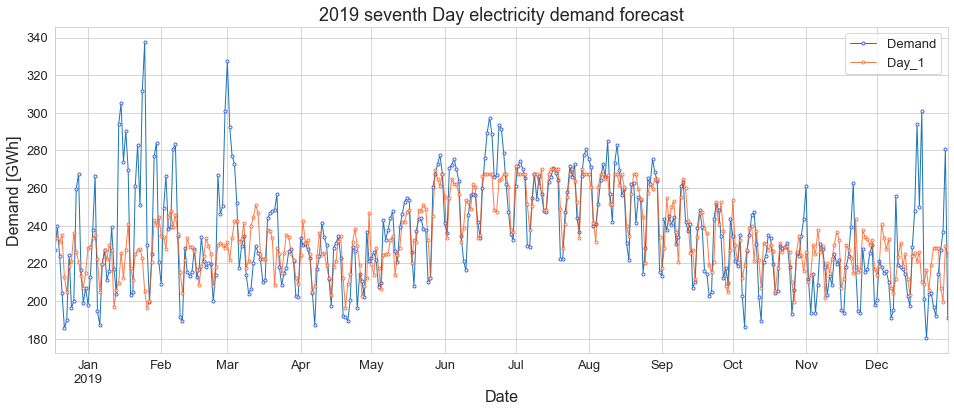

In [25]:
params = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'font.size': 13}
plt.rcParams.update(params)

marker_D = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': 'royalblue'}

color_7 = 'maroon'
color_1 = 'orangered'
marker_F = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': color_1}

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
demo_df[val_start_id-14:test_start_id].plot(x = "Date", y="Demand", **marker_D, lw=1, ax = ax)
demo_df[val_start_id-14:test_start_id].plot(x = "Date", y="Day_1", lw=1, **marker_F, alpha=0.7, ax = ax, c='orangered')
#demo_df[val_start_id-14:test_start_id].plot(x = "Date", y="Day_7", lw=1, **marker_F, alpha=0.7, ax = ax, c='maroon')
ax.set_title("2019 seventh Day electricity demand forecast")
ax.set_ylabel("Demand [GWh]")
None

In [26]:
sns.set_style('ticks')

Text(0.5, 0, 'error magnitude, %')

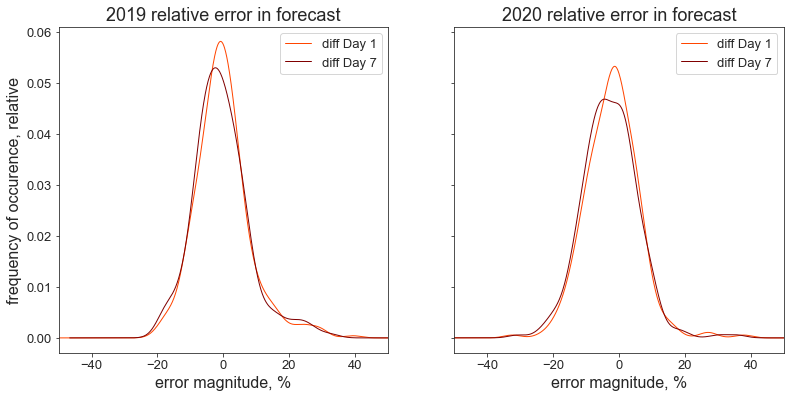

In [27]:
for i in range(7):
    demo_df[f'diff Day {i+1}'] = 100*(1 - demo_df[f'Day_{i+1}']/demo_df['Demand'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

demo_df[val_start_id:test_start_id].plot(x = "Date", y="diff Day 1", ax = ax1, lw = 1, c='orangered', kind='density')
demo_df[val_start_id:test_start_id].plot(x = "Date", y="diff Day 7", ax = ax1, lw = 1, c='maroon', kind='density')
demo_df[test_start_id:-7].plot(x = "Date", y="diff Day 1", ax = ax2, lw = 1, c='orangered', kind='density')
demo_df[test_start_id:-7].plot(x = "Date", y="diff Day 7", ax = ax2, lw = 1, c='maroon', kind='density')
ax1.set_xlim(-50, 50)
ax2.set_xlim(-50, 50)
ax1.set_title("2019 relative error in forecast")
ax2.set_title("2020 relative error in forecast")
ax1.set_ylabel("frequency of occurence, relative")
ax1.set_xlabel("error magnitude, %")
ax2.set_xlabel("error magnitude, %")

Text(0.5, 0, 'magnitude, %')

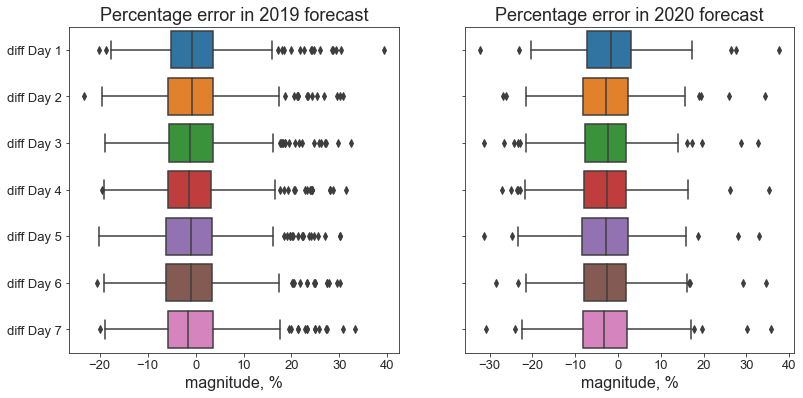

In [28]:
sns.set_style('ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

sns.boxplot(data=demo_df[val_start_id:test_start_id][[f"diff Day {i+1}" for i in range(7)]], ax=ax1, orient='h')
ax1.set_title("Percentage error in 2019 forecast")

sns.boxplot(data=demo_df[test_start_id:-7][[f"diff Day {i+1}" for i in range(7)]], ax=ax2, orient='h')
ax2.set_title("Percentage error in 2020 forecast")

ax1.set_xlabel("magnitude, %")
ax2.set_xlabel("magnitude, %")

In [29]:
mape = [[demo_df[val_start_id:test_start_id][f"diff Day {i+1}"].apply(lambda x: np.abs(x)).mean().round(2) for i in range(7)]]
mape += [[demo_df[test_start_id:-7][f"diff Day {i+1}"].apply(lambda x: np.abs(x)).mean().round(2) for i in range(7)]]
mape = pd.DataFrame(data = mape, columns=[f'Day {i+1}' for i in range(7)], index = [2019, 2020])
mape

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
2019,6.08,6.19,6.27,6.27,6.32,6.43,6.42
2020,6.26,6.73,6.54,6.65,6.67,6.58,6.76
